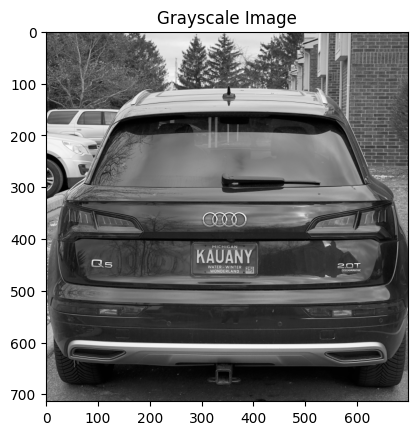

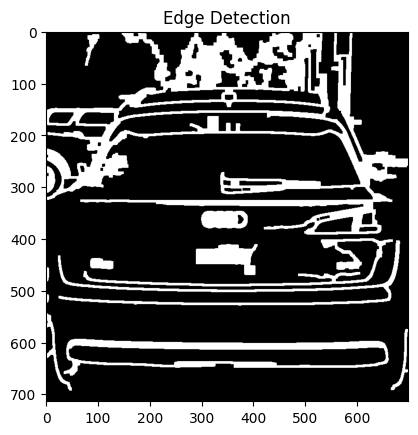

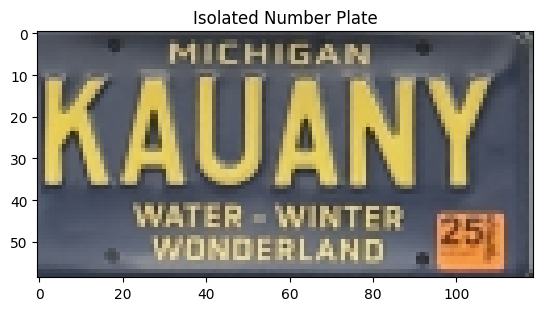

Detected text: KAUANY


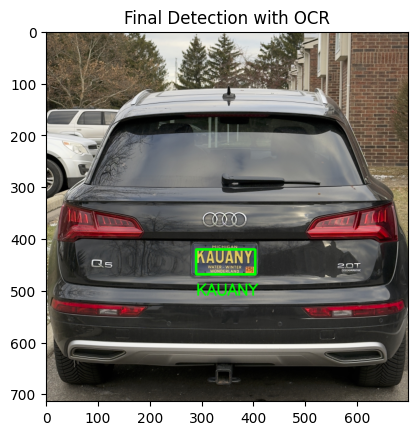

In [314]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

# Path to your image
image_path = '/Users/yatinkande/Downloads/10.jpeg'  # Correct path to your image

# Step 1: Read and preprocess the image
img = cv2.imread(image_path)
if img is None:
    raise ValueError("Image not found or could not be read")

img = imutils.resize(img, width=700)  # Resize for better processing
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Display the grayscale image
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title("Grayscale Image")
plt.show()

# Step 2: Apply GaussianBlur and Canny edge detection to improve edge sensitivity
blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Blur to remove noise
edged = cv2.Canny(blurred, 50, 300)  # Lowering the lower threshold for more edge capture

# Apply stronger dilation to make sure edges are connected
kernel = np.ones((5, 5), np.uint8)  # Larger kernel for dilation
edged = cv2.dilate(edged, kernel, iterations=2)
edged = cv2.erode(edged, kernel, iterations=1)

# Display edge-detected image
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.title("Edge Detection")
plt.show()

# Step 3: Find contours in the edge-detected image
keypoints = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  # Consider top 10 largest contours

location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.05 * cv2.arcLength(contour, True), True)  # More accurate polygon detection
    if len(approx) == 4:  # Look for rectangular contours
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)

        # Filter contours by area and aspect ratio (adjust for better detection)
        if 3500 < cv2.contourArea(contour) < 25000 and 2.0 < aspect_ratio < 5.5:  # Fine-tuned aspect ratio and area range
            location = approx
            break

location

# If number plate location is found
if location is not None:
    # Create a mask for the number plate region
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)  # Fill the contour with white
    new_image = cv2.bitwise_and(img, img, mask=mask)  # Apply the mask to isolate the number plate

    # Crop the number plate region
    (x, y) = np.where(mask == 255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = img[x1:x2+1, y1:y2+1]

    # Display the isolated number plate
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title("Isolated Number Plate")
    plt.show()

    # Step 4: Use EasyOCR to detect text from the cropped image
    reader = easyocr.Reader(['en'])  # Initialize EasyOCR with English language
    result = reader.readtext(cropped_image)  # Detect text from the cropped number plate

    if result:
        # Extract detected text
        text = result[0][-2]
        print(f"Detected text: {text}")  # Print the detected text

        # Overlay the detected text on the original image
        font = cv2.FONT_HERSHEY_SIMPLEX
        res = cv2.putText(img, text=text, org=(location[0][0][0], location[1][0][1] + 60),
                          fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
        res = cv2.rectangle(img, tuple(location[0][0]), tuple(location[2][0]), (0, 255, 0), 3)

        # Display the final result with the detected text
        plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
        plt.title("Final Detection with OCR")
        plt.show()
    else:
        print("No text detected in the license plate region")
else:
    print("Number plate location could not be identified.")
